In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamWeightDecay, pipeline, create_optimizer, Trainer, TrainingArguments
from transformers import DefaultDataCollator
from datasets import load_metric
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from datasets import Dataset
import numpy as np
import plotly.express as px
import plotly.io as pio
import pandas as pd
import math
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
os.environ["TOKENIZERS_PARALLELISM"] = "false"
pio.renderers.default = 'notebook_connected'
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
import gensim
from gensim import corpora, models, similarities
%matplotlib inline
# Flag to let us know if we're currently running in Google Colab or locally
import sys
IN_COLAB = 'google.colab' in sys.modules

2023-03-28 17:08:10.441512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda/envs/Python3/lib:
2023-03-28 17:08:10.441546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faculty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tokenizer_auto = AutoTokenizer.from_pretrained("gpt2")
tokenizer_auto.pad_token = tokenizer_auto.eos_token
auto_model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer_auto.eos_token_id)


In [4]:
data= pd.read_csv('/project/nlp_text_generation_sentences_data_all_champions.csv')
data_full_train_val, test_set_full = train_test_split(data, test_size=0.2, random_state=200)

data_full_train_val = Dataset.from_pandas(data_full_train_val)
data_full_train_val = data_full_train_val.train_test_split(shuffle = True, seed = 200, test_size=0.25)
train = data_full_train_val["train"]
val = data_full_train_val["test"]


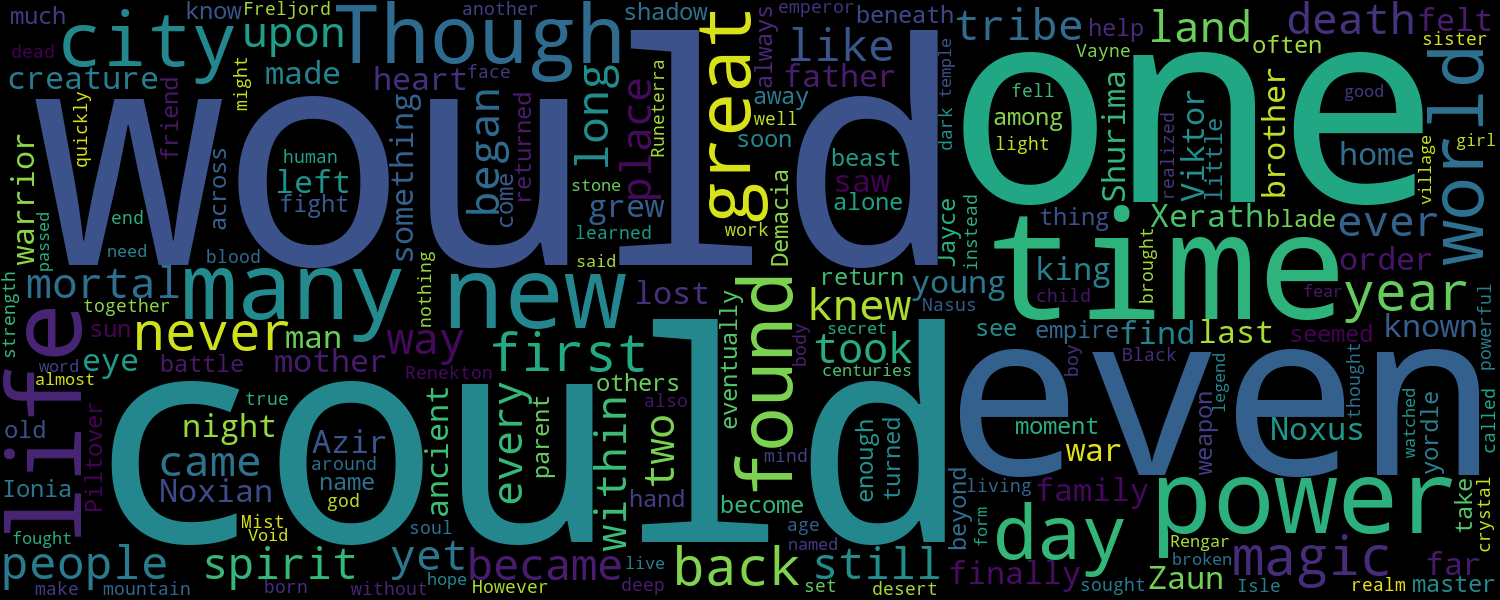

In [5]:
## have to get rid of the stopping words in word cloud
alldata = pd.Series(data["sentences"]).str.cat(sep=' ').replace("\n", " ")
wordcloud = WordCloud(collocations=False, 
                                width=1500, 
                                height=600, 
                                stopwords=stopwords.words("english")
                            ).generate(alldata)
fig = px.imshow(wordcloud, labels=dict(x="Most frequent words in all the biography"))
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

fig.write_image("wordcloud.png")
fig.show(config={"displayModeBar": False})


In [6]:

sentences = [len(x.split()) for x in data["sentences"]]
px.histogram(sentences, nbins=400, marginal="rug", labels={"value":"Sentences Length (words)"})


In [7]:
sentences = [len(x.split()) for x in data["sentences"]]
fig = px.histogram(sentences, nbins=400, marginal="rug", labels={"value":"Sentences Length (words)"})
fig.write_image("sentences_histogram.png")

In [47]:
def tokenization(data):
    tokens = tokenizer_auto(data["sentences"], padding="max_length", truncation=True, max_length=70)
    return tokens

# Apply the tokenizer in batch mode and drop all the columns except the tokenization result
train_token = train.map(tokenization, batched = True, remove_columns=["Unnamed: 0", "champion"], num_proc=10)
val_token = val.map(tokenization, batched = True, remove_columns=["Unnamed: 0", "champion"], num_proc=10)



Map (num_proc=10):   0%|          | 0/3430 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/1144 [00:00<?, ? examples/s]

In [48]:
train_token[]

Dataset({
    features: ['sentences', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 3430
})

In [7]:
def create_labels(text):
    text["labels"] = text["input_ids"].copy()
    return text

# Add the labels column using map()
lm_train = train_token.map(create_labels, batched=True, num_proc=10)
lm_val = val_token.map(create_labels, batched=True, num_proc=10)

Map (num_proc=10):   0%|          | 0/3430 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/1144 [00:00<?, ? examples/s]

In [ ]:
# from sklearn.metrics import log_loss
# import torch.nn.functional as F

# def compute_metrics(pred):
#     logits = torch.from_numpy(pred.predictions)
#     labels = torch.from_numpy(pred.label_ids)
#     loss = F.cross_entropy(logits.view(-1, tokenizer.vocab_size), labels.view(-1))
#     return {'perplexity': math.exp(loss), 'calculated_loss': loss}

In [ ]:
learning_rates = [0.001, 0.0001, 0.00005] #
weight_decays = [0.01, 0.005, 0.001] #, 
epochs= [1,2,3]
best_result= None
best_loss=  float('inf')

for epoch in epochs:
    for lr in learning_rates:
        for wd in weight_decays:
            auto_model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
            training_args = TrainingArguments(output_dir=f'./results', 
                                              num_train_epochs= epoch, 
                                              logging_strategy="epoch",
                                              #logging_steps=20, 
                                              save_strategy="epoch",
                                              #save_steps=20,
                                              evaluation_strategy='epoch',
                                              #eval_steps=20,
                                              learning_rate= lr ,
                                              per_device_train_batch_size=10, 
                                              per_device_eval_batch_size=10,
                                              #warmup_steps=5, 
                                              weight_decay=wd, 
                                              logging_dir='./logs',
                                              load_best_model_at_end=True)


            trainer = Trainer(model=auto_model,  
                              args=training_args, 
                              train_dataset=lm_train, 
                              eval_dataset=lm_val)
            #                    compute_metrics=compute_metrics)


            trainer.train()   

            result = trainer.evaluate(eval_dataset=lm_val)

            # Check if the current result is the best so far
            if result['eval_loss'] < best_loss:
                best_loss = result['eval_loss']
                best_result = {'epoch': epoch, 'learning_rate': lr, 'weight_decay': wd, 'eval_loss': best_loss}                
                trainer.save_model(f'./best_model')
            #reset the model for the next loop of training     
print('Best result:', best_result)



In [14]:
best_result={'epoch': 3, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'eval_loss': 1.2700029611587524}

In [15]:
#the best result in the grid search
print('Best result:', best_result)

Best result: {'epoch': 3, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'eval_loss': 1.2700029611587524}


In [16]:
perplexity =math.exp(best_result['eval_loss'])
print(perplexity)

3.560863106620863


In [37]:
#callback the besst model
best_model = AutoModelForCausalLM.from_pretrained(f'./best_model')

In [38]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.add_special_tokens({'bos_token': '<BOS>'})
tokenizer.add_special_tokens({'eos_token': '<EOS>'})
tokenizer.add_special_tokens({'sep_token': '[SEP]'})

1

In [39]:
text_generator = pipeline(
    "text-generation",
    model=best_model,
    tokenizer=tokenizer_auto,
    framework="pt",
    temperature=1.0,
    top_k=50,
    top_p=0.9,
    do_sample=True,
    min_length= 100,
    min_new_tokens=0, 
    max_new_tokens=100)

In [40]:
test_sentence = "A strong, lawful kingdom with a prestigious military history"
text_generator(test_sentence)[0]["generated_text"].replace("\n", " ")

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/transformers/generation/utils.py:1201: UserWarning:

You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)



'A strong, lawful kingdom with a prestigious military history. But a broken king, who could rule only by means of the sword, would not rule any other way. He would not seek to rule alone. He would seek to create an unending tide of violence. He would not hesitate to do what was right, and when the storm reached its peak, he would seize control of all lands for himself, and destroy all enemies.The First Lands were his greatest asset. As a child, the kingdom’s wealth grew and grew.'

Error Analysis

BLEU for test set (examining the quality of the generated text)

Full Model

In [17]:
best_model = AutoModelForCausalLM.from_pretrained(f'./best_model')

In [18]:
#min_length= 100: the longest sentence in a row is 100, and the function below includes the prompt, if below 100, it generates na value.
text_generator_full_bleu = pipeline(
    "text-generation",
    model=best_model,
    tokenizer=tokenizer_auto,
    framework="pt",
    temperature=1.0,
    top_k=50,
    top_p=0.9,
    do_sample=True,
    min_length= 100,
    max_length= 200)

In [19]:
#wrap the text generation pipeline into the function to apply on each row in the dataset
def generate_text_bleu(test_sentence):
    generated_text=text_generator_full_bleu(test_sentence)[0]["generated_text"].replace("\n", " ")
    generated_text = generated_text[len(test_sentence):].lstrip()
    return generated_text

In [20]:
generate_text_bleu("A strong, lawful kingdom with a prestigious military history")

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/transformers/generation/utils.py:1201: UserWarning:

You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)



', this prince had fought alongside his brothers.   The Crownguard was proud to have been crowned king; they had been raised by the emperor’s blessing to crown themselves with the title of true knights.   But the prince had been disappointed by how badly their new crown had failed them. He would not admit defeat, and pledged the people to him that his life would be spared to defend the realm.   A band of warbands led by Anivia awaited the return of his father, Anivia, and a duel to the death.'

In [127]:
test_set_full['label']= test_set_full.shift(-1)["sentences"]
test_set_full= test_set_full.dropna()
test_set_full['generated']= test_set_full['sentences'].apply(lambda x : generate_text_bleu(x))

In [128]:
print(test_set_full['generated'])

5701    “The truth is, I needed someone to look after ...
3914    Nor had she expected that the one she loved th...
619     The battle for the throne was a grueling one f...
3008    ’I can see her as a friend, and a teacher.’ ’ ...
879     As a young warrior who fell in love with his h...
                              ...                        
839     Kunai was a proud warrior, but he always treat...
5067    At this moment, Azir’s mind was at rest. He fe...
2989    The last thing she knew was that she was too o...
1781    He was the greatest warrior ever. At last, Rak...
680     Singer Yasuo made sure to follow the flow of t...
Name: generated, Length: 1139, dtype: object


In [129]:
BLEU_full= bleu(test_set_full['label'].tolist(),test_set_full['generated'].tolist())

In [130]:
print(BLEU_full)

0.003328753346459481


BERT SCORE

In [131]:
text_generator_story = pipeline(
    "text-generation",
    model=best_model,
    tokenizer=tokenizer_auto,
    framework="pt",
    temperature=0.9,
    top_k=120,
    top_p=0.9,
    do_sample=True,
    min_length= 240,
    max_length= 300,
    min_new_tokens=0,
    num_return_sequences=2)

In [40]:
#original 240 words
original=""" 
Two sisters. Two cities. One discovery that will change the world forever. In the cities of Piltover and Zaun, unrest stirs as inventors and thieves, politicians and crime lords chafe against the constraints of a society torn asunder. As dissent reaches a fever pitch, two sisters steal an artifact of untold power. Discovery and danger intertwine as heroes are born and bonds are broken. Will this power change the world, or lead it to ruin? This is the world of Arcane. Nestled at the heart of the continent, Piltover stands on the precipice of progress. The invention of hextech shines with subtle promise of a glorious future, and two brilliant scientists lead the charge. Such potential is not without cost, and failure could prove devastating as politicians vie for a power they barely understand. As unrest stirs in the Undercity and upheaval looms, the people of Piltover must protect their future… no matter the cost. In the shadows of progress, far below the ivory towers of Piltover, the Undercity waits. The air there is thick with shouts and smoke, and each alleyway promises danger, desire...or both. But at its heart, this sister city thrums with hope, ingenuity, and an unbreakable spirit that neither greedy chembarons nor aggressive enforcers could ever take away. As the age of hextech looms, her citizens no longer see themselves as Topsiders. Instead, they look up with desperate determination and dream of something more. 
"""
#new story38 words
new_story_prompt = "Two sisters. Two cities. One discovery that will change the world forever. In the cities of Piltover and Zaun, unrest stirs as inventors and thieves, politicians and crime lords chafe against the constraints of a society torn asunder."
generated_story_full= text_generator_story(new_story_prompt)[0]["generated_text"].replace("\n", " ")

In [42]:
len(original.split(" "))

240

In [43]:
len(new_story_prompt.split(" "))

38

In [41]:
print(generated_story_full)

Two sisters. Two cities. One discovery that will change the world forever. In the cities of Piltover and Zaun, unrest stirs as inventors and thieves, politicians and crime lords chafe against the constraints of a society torn asunder. Piltover is a city of trade and commerce that, as it is now, is the best of the great civilizations for their region. Piltover is where foreign goods can be found and sold, and where trade is made as easy as pie. Piltover is where innovation can thrive, and where innovation is always welcomed. Piltover is where the very fabric of humanity grows with each passing day, and where innovation is all that lies beneath. Piltover’s future is uncertain.


In [134]:
print(generated_story_full)

Two sisters. Two cities. One discovery that will change the world forever. In the cities of Piltover and Zaun, unrest stirs as inventors and thieves, politicians and crime lords chafe against the constraints of a society torn asunder. Piltover is the last bastion of civilization left to defend itself. Piltover is the gateway to the new realms, and yet it is also the gateway to the next. Piltover’s fate lies at the head of a strange and unknowable chain of events: Piltover may once again be known as the Great City of Progress. Piltover’s inhabitants are the world’s most powerful magic-workers, and so far, none have dared venture beyond it. Piltover’s vast, open spaces are not the only places the people of Piltover are unique, and yet they are the only places in the world where magic is freely spread throughout the universe. Piltover is a dangerous place—the world has become a grim and dangerous place. Piltover’s magic grows in complexity, both in size and intensity. Piltover is not the 

In [135]:
len(generated_story_full.split(' '))

179

In [136]:
def get_similarity(embedding_1:np.array, embedding_2:np.array) -> float:
  dot_product = np.dot(embedding_1, embedding_2)
  norm1 = np.linalg.norm(embedding_1)
  norm2 = np.linalg.norm(embedding_2)
  cosine_similarity = dot_product / (norm1 * norm2)
  return cosine_similarity  

In [137]:
from transformers import AutoTokenizer, AutoModel
import torch

# Initialize the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Encode the sentences using the BERT tokenizer
encoded_input_1 = tokenizer(original, padding=True, truncation=True, return_tensors='pt')

# Pass the encoded input through the BERT model to obtain the document embeddings
outputs = model(**encoded_input_1)

document_embeddings_1 = outputs.last_hidden_state[:, 0, :]
document_embeddings_1 = document_embeddings_1.detach().numpy()

# Encode the sentences using the BERT tokenizer
encoded_input_2 = tokenizer(generated_story_full, padding=True, truncation=True, return_tensors='pt')

# Pass the encoded input through the BERT model to obtain the document embeddings
outputs = model(**encoded_input_2)

document_embeddings_2 = outputs.last_hidden_state[:, 0, :]
document_embeddings_2 = document_embeddings_2.detach().numpy()
similarity_bert = get_similarity(document_embeddings_1[0], document_embeddings_2[0])
print(similarity_bert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.9163937


Topic modeling similarity

In [193]:
seeds=list(range(1, 1000))

cos_sim_l=[]

# preprocess the text by tokenizing and removing stop words
texts = [gensim.utils.simple_preprocess(story) for story in [original, generated_story_full]]

# create a dictionary of unique terms in the text
dictionary = corpora.Dictionary(texts)

# convert the text into a bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in texts]

for s in list(range(100, 900, 300)):

    #set the seed for LDA model
    np.random.seed(s) 
    # perform LDA topic modeling on the corpus
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2)

    # extract the topic distributions for each document
    doc1_topics = lda_model.get_document_topics(corpus[0])
    doc2_topics = lda_model.get_document_topics(corpus[1])

    # compare the topic distributions using cosine similarity
    similarity = similarities.MatrixSimilarity([doc1_topics])
    cos_sim = similarity[doc2_topics][0]
    cos_sim_l.append(cos_sim)

# print the similarity score
print(cos_sim_l)
print(cos_sim_l)
print("Cosine similarity:", sum(cos_sim_l)/len(cos_sim_l))

[0.30297595, 1.0, 0.6232952]
[0.30297595, 1.0, 0.6232952]
Cosine similarity: 0.642090380191803


In [174]:
# preprocess the text by tokenizing and removing stop words
texts = [gensim.utils.simple_preprocess(story) for story in [original, generated_story_full]]

# create a dictionary of unique terms in the text
dictionary = corpora.Dictionary(texts)

# convert the text into a bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in texts]
#set the seed for LDA model
np.random.seed(100) 
# perform LDA topic modeling on the corpus
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2)

# extract the topic distributions for each document
doc1_topics = lda_model.get_document_topics(corpus[0])
doc2_topics = lda_model.get_document_topics(corpus[1])

# compare the topic distributions using cosine similarity
similarity = similarities.MatrixSimilarity([doc1_topics])
cos_sim = similarity[doc2_topics][0]
print(cos_sim)

0.30297595


Human evaluation

In [28]:
text_generator_story = pipeline(
    "text-generation",
    model=best_model,
    tokenizer=tokenizer_auto,
    framework="pt",
    temperature=1.0,
    top_k=120,
    top_p=0.9,
    do_sample=True,
    min_length= 150,
    max_length= 200,
    min_new_tokens=0,
    num_return_sequences=2)

In [29]:
prompt_bio1=""" 
Piltover is a thriving, progressive city whose power and influence is on the rise. It is Valoran’s cultural center, where art, craftsmanship, trade and innovation walk hand in hand. Its power comes not through military might, but the engines of commerce and forward thinking.
"""

In [24]:
target_bio1= """
Few dared to rebel. Those that did, like the accursed nation of Icathia, were crushed without mercy.
However, after several thousand years of growth and prosperity, the failed Ascension of Shurima’s last emperor left the capital in ruins, and tales of the empire’s former glory became little more than myth. Now, most of the nomadic inhabitants of Shurima’s deserts eke out a meager existence from the unforgiving land. Some have built small outposts to defend the few oases, while others delve into long lost catacombs in search of the untold riches that must surely lay buried there. There are also those who live as mercenaries, taking coin for their service before disappearing back into the lawless wastelands.Still, a handful dare to dream of a return to the old ways. Indeed, more recently the tribes have been stirred by whispers from the heart of the desert—that their emperor Azir has returned, to lead them into a new, wondrous age.
"""

In [27]:
len(target_bio1.split(" "))

157

In [31]:
text_generator_story(prompt_bio1)[0]["generated_text"].replace("\n", " ")

'  Piltover is a thriving, progressive city whose power and influence is on the rise. It is Valoran’s cultural center, where art, craftsmanship, trade and innovation walk hand in hand. Its power comes not through military might, but the engines of commerce and forward thinking. -Ulla. She has spent her life as a member of the Order of the Shadow, a new alliance of guardians fighting against the darkin’s encroachment on a realm ruled by powerful, but monolithic empires. In that conflict, they have defeated the enemy of all who oppose their power and been victorious. -Senna. -Aquinas. He has spent his life fighting to end the war in Kalimdor, fighting to overturn a new coalition of celestial allies that are already encroaching upon the land.'

In [32]:
prompt_bio2="""
The empire of Shurima was once a thriving civilization that spanned an entire continent. Forged in a bygone age by the mighty god-warriors of the Ascended Host, it united all the disparate peoples of the south, and enforced a lasting peace between them.
"""

In [37]:
target_bio2= """
Few dared to rebel. Those that did, like the accursed nation of Icathia, were crushed without mercy.
However, after several thousand years of growth and prosperity, the failed Ascension of Shurima’s last emperor left the capital in ruins, and tales of the empire’s former glory became little more than myth. Now, most of the nomadic inhabitants of Shurima’s deserts eke out a meager existence from the unforgiving land. Some have built small outposts to defend the few oases, while others delve into long lost catacombs in search of the untold riches that must surely lay buried there. There are also those who live as mercenaries, taking coin for their service before disappearing back into the lawless wastelands.
Still, a handful dare to dream of a return to the old ways. Indeed, more recently the tribes have been stirred by whispers from the heart of the desert—that their emperor Azir has returned, to lead them into a new, wondrous age.
"""

In [38]:
len(target_bio2.split(" "))

157

In [39]:
text_generator_story(prompt_bio2)[0]["generated_text"].replace("\n", " ")

' The empire of Shurima was once a thriving civilization that spanned an entire continent. Forged in a bygone age by the mighty god-warriors of the Ascended Host, it united all the disparate peoples of the south, and enforced a lasting peace between them. There are many tales of how he came to be at the center of this conflict, and his first appearance was when a band of nomadic warriors invaded the neighboring land. It was during the war that Nasus’s first memories came to be. At the height of it all, he was one of the few survivors of an ancient battle, and endured the bitter end to it all. The Shuriman warbands of Noxus had marched onto the eastern coast of the Noxus to ravage the lands and villages of Runeterra.'

In [53]:
original = {'Language quality': [9.50, 8.67, 8.17, 8.17, 9.17, 9.00, 8.83, 8.67, 8.83, 8.17, 9.67, 7.83, 8.50, 9.50, 8.00, 8.83, 9.33, 8.17, 8.67, 9.83],
            'Coherence': [8.67, 9.00, 8.33, 9.00, 9.00, 8.17, 7.83, 7.83, 8.33, 8.17, 5.83, 8.33, 8.00, 8.83, 8.17, 8.67, 8.50, 7.83, 9.17, 8.33],
            'Creativity': [8.50, 8.33, 7.00, 8.00, 7.00, 7.00, 6.33, 6.50, 4.67, 5.33, 7.50, 7.33, 7.33, 8.33, 6.83, 7.67, 8.17, 6.67, 7.33, 7.50]}

# Generated data
generated = {'Language quality': [7.33, 7.50, 6.83, 7.67, 7.17, 7.33, 7.33, 7.83, 7.17, 8.00, 8.17, 7.67, 8.50, 7.83, 8.00, 8.50, 7.67, 8.67, 8.33, 8.17],
             'Coherence': [7.50, 7.67, 7.33, 7.33, 6.50, 7.33, 6.33, 7.00, 7.33, 5.17, 8.50, 7.50, 7.83, 6.67, 8.83, 6.83, 7.67, 7.67, 7.17, 8.50],
             'Creativity': [6.83, 7.00, 7.50, 7.17, 6.00, 6.17, 6.33, 6.50, 7.00, 7.33, 6.83, 6.67, 7.00, 7.67, 5.50, 7.67, 6.83, 6.83, 7.83, 7.67]}


In [54]:
# Create dataframes
original_df = pd.DataFrame(original)
generated_df = pd.DataFrame(generated)

In [57]:
original_mean = original_df.mean()
original_mean

Language quality    8.7755
Coherence           8.2995
Creativity          7.1660
dtype: float64

In [58]:
generate_mean = generated_df.mean()
generate_mean

Language quality    7.7835
Coherence           7.3330
Creativity          6.9165
dtype: float64

In [59]:
all_values = np.array([original_mean, generate_mean])

In [63]:
colors = ['blue', 'orange']

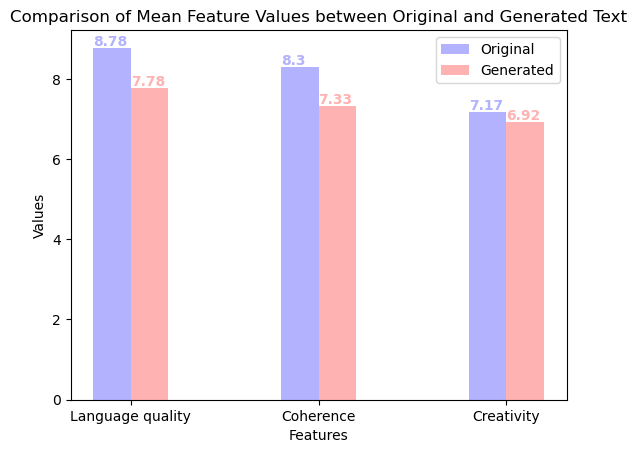

In [113]:
barWidth = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(original_mean))
r2 = [x + barWidth for x in r1]

# Plot the bars
plt.bar(r1, original_mean, color='b', width=barWidth, label='Original', alpha=0.3)
plt.bar(r2, generate_mean, color='r', width=barWidth, label='Generated', alpha=0.3)

# Add x-axis labels and title
plt.xticks([r + barWidth/2 for r in range(len(original_mean))], ['Language quality', 'Coherence', 'Creativity'])
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Comparison of Mean Feature Values between Original and Generated Text')

# Add a legend
plt.legend()

for i, v in enumerate(original_mean):
    plt.text(i - barWidth/2, v + 0.05, str(round(v,2)), color='b', fontweight='bold', alpha=0.3)
for i, v in enumerate(generate_mean):
    plt.text(i + barWidth/2, v + 0.05, str(round(v,2)), color='r', fontweight='bold', alpha=0.3)

    
plt.savefig('histogram.png')
# Show the plot
plt.show()


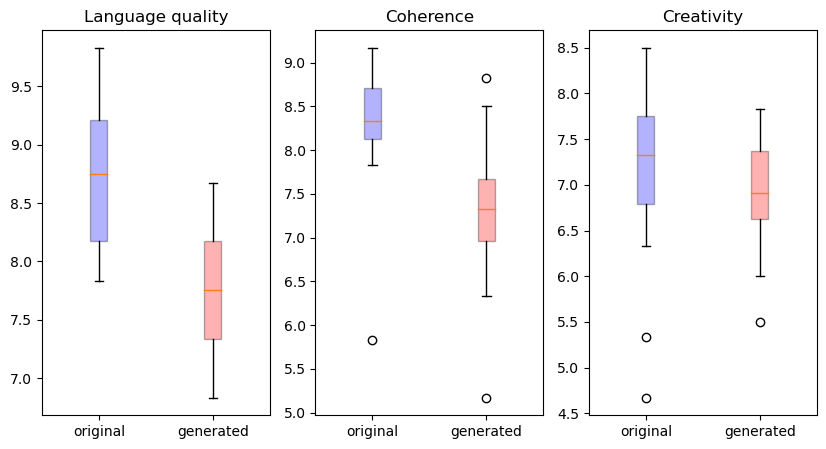

In [107]:
# create a list of data frames
dfs = [original_df, generated_df]

# create a list of column names
cols = ['Language quality', 'Coherence', 'Creativity']


# create a figure with subplots for each column
fig, axs = plt.subplots(1, len(cols), figsize=(10,5))

# set the colors and alpha for each label
colors = {'original_df': 'blue','generated_df': 'red'}
alpha = {'original_df': 0.3, 'generated_df': 0.3}

# create a boxplot for each column in each data frame
for i, col in enumerate(cols):
    bplot = axs[i].boxplot([original_df[col], generated_df[col]], labels=['original', 'generated'], patch_artist=True)
    for patch, label in zip(bplot['boxes'], ['original_df', 'generated_df']):
        patch.set_facecolor(colors[label])
        patch.set(facecolor=colors[label], alpha=alpha[label])
    axs[i].set_title(col)

# display the plot
plt.show()
fig.savefig('boxplot.png')